## Data de entrega: 16/03/22
Email: andre.juan.prof@gmail.com
_________

# Projeto módulos ML - Introdução

____________

## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC.**


## Base de Dados

Serão utilizadas bases de dados com **informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, subdividindo tal base como a squad achar melhor. 

Existe também os das variáveis explicativas, para ajudar no desenvolvimento do projeto. 

Serão necessários diversos cruzamentos e vocês estão livres para usar os dados da maneira que acharem mais conveniente.

[Clique aqui](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view) pra baixar os dados (eles estão disponiveis no arquivo zipado `credito-imoveis.zip`).

## Regras de Entrega

Deve ser entregue um arquivo csv com as **predições** para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o **SK_ID_CURR** e a segunda a **probabilidade de inadimplência.**

### IMPORTANTE!

Entregar as predições com a **probabilidade da inadimplência ocorrer**, não a classe predita.

Além do arquivo com as predições, claro, entreugem também o notebook com o código utilizado. É importante que ele tenha:

- (i) a análise exploratória e construção das variáveis explicativas;

- (ii) a análise de modelagem, mostrando o processo das avaliações dos modelos e os motivos das decisões tomadas sobre qual modelo usar.

## Dicas


Explorar o conceito das variáveis: existe risco de imagem uma empresa utilizar variável de sexo para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade!

Qualquer dúvida, só me chamar! ;)


## Observações adicionais

- No arquivo zipado, há todas as bases que foram utilizadas na criação das bases principais (`application_{train|test_student}`). Vocês podem explorar à vontade estas outras bases pra entender como elas se comunicam entre si, e como as informações delas foram agregadas na base principal. No entanto, **não é necessário utilizar estas informações**, basta usar apenas o que tem na base de treino `application_train`. Este trabalho de cruzamento de diversas bases para a construção de uma única base de treinamento é muito importante, mas (embora já saibamos como cruzar bases!), é algo que foge do escopo deste módulo -- no módulo de banco de dados, vcs vão aprender tudo sobre isso! ;)

- Reflitam sobre isso: da forma que está, a base de teste `application_test_student` serve pra quê?

- Reforçando, pq nunca é demais: não esqueçam de fazer uma extensa análise exploratória! **Conheçam o problema com o qual vcs estão trabalhando!** Essa é a hora de botar em prática ao extremo tudo o que vimos no módulo 3 e 4! (e o que vimos no módulo 5 na etapa de modelagem, claro hehe)


## Alguns benchmarks

Pra ter uma ideia da performance máxima esperada do modelo, sugiro dar uma olhada nos [notebooks da competição](https://www.kaggle.com/c/home-credit-default-risk/code?competitionId=9120&sortBy=voteCount) (usem apenas como referência/inspiração! Peço que, na solução de vocês, realmente vcs apliquem as coisas como vimos no curso!!)

Em alguns notebooks, podemos ver que as AUC/ROCs máximas de validação encontradas foram de **0.76** e até mesmo **0.78** (usando modelos de gradient boosting e um pouco de feature engineering). Acredito que esse pode ser o alvo teto pra performance de vocês -- embora, como sempre dizemos: tentem chegar o mais próximo possível, no tempo que vocês têm disponível! Então, se não chegarem exatamente nessa performance, tudo bem! O importante é tentar chegar o mais próximo possível ;)

# Home Credit Default Risk Analysis

## Table of Contents

1. [Libraries and Functions imports](#imports)
2. [Exploratory Data Analysis](#eda)
	- [Reading data](#read)
	- [Visualizing null values](#na)
	- [Features types](#dtypes)
	- [Encoding categorical variables](#encoding)
	- [Data correlation](#corr)
	- [Target distribuition](#target_dist)
	- [Search for Outliers](#outliers)
3. [First Cycle - Baseline Model](#baseline)
4. [Second Cycle - Improving Model with Hyper-parameter tunning](#cycle2)
5. [Third Cycle - Using other estimators](#cycle3)
	- [Random Forest](#rf)
	- [Gradient Boosting](#gb)
	- [XGBoost](#xgb)
6. [Interpreting Results](#results)
7. [Deploy Model](#deploy)


## <span id='imports' style='color:Gold'>1. Libraries and Functions

In [1]:
from IPython.core.display import display
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime

# disable warning 
import warnings
warnings.filterwarnings('ignore')

# color pallete
colors = {
    'cyan': '#1696d2',
    'gray': '#5c5859',
    'black': '#000000',
    'yellow': '#fdbf11',
    'orange': '#ca5800',
    'magenta': '#af1f6b',
    'green': '#408941',
    'red': '#a4201d'
}

# terminal colors
WHITE = '\033[39m'
CYAN = '\033[36m'
GREEN = '\033[32m'
RED = '\033[31m'

# pandas config
# supress large scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# increase range of columns to view
pd.set_option('display.max_columns', None)

# libraries version
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
import sklearn
print(f'Sklearn: {sklearn.__version__}')
import matplotlib
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')

# aux functions

def display_na(df):
    plt.figure(figsize=(18,30))
    sns.heatmap(df.loc[:, df.isna().any()].isna().transpose(),
                cmap="GnBu",
                cbar_kws={'label': 'Missing Data'})
    plt.title('Heatmap showing Missing Values', weight='bold', fontsize=18, pad=20, loc='left')
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show();

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, precision_recall_curve

def display_classification_metrics(estimator, X_train, X_test, y_train, y_test, 
									plot_roc_auc=True, plot_confusion_matrix=True, plot_precision_recall=True):

	# predict for train/test
	y_pred_train = estimator.predict(X_train)
	y_pred_test = estimator.predict(X_test)
	# predict proba for train/test
	y_proba_train = estimator.predict_proba(X_train)
	y_proba_test = estimator.predict_proba(X_test)

	# Calculate ROC AUC Score
	print(f'{CYAN}ROC AUC Score for Train dataset:{WHITE} {roc_auc_score(y_train, y_proba_train[:,1])}')
	print(f'{CYAN}ROC AUC Score for Test dataset:{WHITE} {roc_auc_score(y_test, y_proba_test[:,1])}')
	print()
	# Classification report: precision, recall, f1-score
	print(f'{CYAN}Train data Classification Report:{WHITE}\n',classification_report(y_train, y_pred_train))
	print(f'{CYAN}Test data Classification Report:{WHITE}\n',classification_report(y_test, y_pred_test))

	if plot_roc_auc:
		# get false positive rates and true positive rates
		fpr, tpr, _ = roc_curve(y_test, y_proba_test[:,1])
		# score for test dataset
		score = round(roc_auc_score(y_test, y_proba_test[:,1]),3)
		# plot ROC AUC curve
		plt.figure(figsize=(8,6))
		plt.plot(fpr, tpr, label=f'Classifier AUC = {score}')
		plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), ls=':', label='Random = 0.5')
		plt.title('ROC AUC curve', fontsize=18, pad=20, loc='left')
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		plt.legend()
		plt.tight_layout()
		plt.show()

	if plot_precision_recall:
		# get precisions, recalls and thres
		precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test[:,1])
		# plot Precision-Recall curve
		plt.figure(figsize=(8,6))
		plt.plot(thresholds, precisions[:-1], label='Precision')
		plt.plot(thresholds, recalls[:-1], label='Recall', color='black')
		plt.title('Precision-Recall curve', fontsize=18, pad=20, loc='left')
		plt.xlabel('Tresholds cutoffs')
		plt.legend()
		plt.tight_layout()
		plt.show()
		
	if plot_confusion_matrix:
		fig, ax = plt.subplots(1,2,figsize=(10,6))
		# plot Confusion Matrix from Train dataset
		fig.suptitle('Confusion Matrix', size=22)
		ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax[0], colorbar=False)
		ax[0].grid(False)
		ax[0].set_title('Train dataset', size=18, pad=20)

		# plot Confusion Matrix from Test dataset
		cf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax[1], colorbar=False)
		ax[1].grid(False)
		ax[1].set_title('Test dataset', size=18, pad=20)
		
		# coordinates to plot colorbar on the right plot
		cax = plt.axes([0.95, 0.21, 0.03, 0.60])
		plt.colorbar(cf.im_, cax=cax)
		plt.show()

Numpy: 1.20.3
Pandas: 1.3.4
Sklearn: 1.0.2
Matplotlib: 3.4.3
Seaborn: 0.11.2


## <span id='eda' style='color:Gold'>2. Exploratory Data Analysis

Exploratory data analysis will cover to following workflow:
- Read the files, both test and train data, check their sizes and number of features  
- Visualize the null values ​​and calculate how much they represent in relation to the total data  
- Check each column types, for numeric discrete/continuous or object categorical variables  
- Encode categorical variables for later processing 
- Examine target variable distribuition  
- Visualize data correlation to find insights  
- Treat possible outliers or inconsistent values in features  
- Select candidate for future feature engineering  

### <span id='read' style='color:#1696d2'>Reading data</span>

The following file `HomeCredit_columns_description.csv` contains detailed information about each column.  
  
*Obs: if any endocing error occurs when reading with pd.read_csv, just open the file in any editor, save, close and try again.*

In [2]:
df_description = pd.read_csv('data/HomeCredit_columns_description.csv')
df_description.drop('Unnamed: 0', axis=1, inplace=True)
df_description

Table                    Row  \
0    application_{train|test}.csv             SK_ID_CURR   
1    application_{train|test}.csv                 TARGET   
2    application_{train|test}.csv     NAME_CONTRACT_TYPE   
3    application_{train|test}.csv            CODE_GENDER   
4    application_{train|test}.csv           FLAG_OWN_CAR   
..                            ...                    ...   
214     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215     installments_payments.csv        DAYS_INSTALMENT   
216     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217     installments_payments.csv         AMT_INSTALMENT   
218     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 4 columns]

In [3]:
df_train = pd.read_csv('data/application_train.csv')
print(f'Train dataset info\nObservations: {df_train.shape[0]}\nFeatures: {df_train.shape[1]}')
df_train.head()

Train dataset info
Observations: 246008
Features: 122


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      456162       0         Cash loans           F            N   
1      134978       0         Cash loans           F            N   
2      318952       0         Cash loans           M            Y   
3      361264       0         Cash loans           F            N   
4      260639       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               N             0        112500.000  700830.000    22738.500   
1               N             0         90000.000  375322.500    14422.500   
2               N             0        180000.000  544491.000    16047.000   
3               Y             0        270000.000  814041.000    28971.000   
4               Y             0        144000.000  675000.000    21906.000   

   AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0       585000.000   Unaccompanied               Working   
1       324000.000   Unaccompanied  Commercial associate   
2       454500.000   Unaccompanied               Working   
3       679500.000   Unaccompanied             Pensioner   
4       675000.000   Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0              Incomplete higher  Single / not married  House / apartment   
1  Secondary / secondary special               Married  House / apartment   
2  Secondary / secondary special               Married  House / apartment   
3  Secondary / secondary special               Married  House / apartment   
4  Secondary / secondary special             Separated  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.020       -8676           -813          -4163.000   
1                       0.025      -13583           -223          -3554.000   
2                       0.036      -13993          -6202          -7971.000   
3                       0.046      -22425         365243         -11805.000   
4                       0.026      -18839          -2763          -5069.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -1363          NaN           1               1                1   
1            -3287          NaN           1               1                0   
2            -4175        9.000           1               1                1   
3            -1732          NaN           1               0                0   
4            -2381          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL        OCCUPATION_TYPE  \
0                 1           0           0             Core staff   
1                 1           0           0  High skill tech staff   
2                 1           0           0               Managers   
3                 1           1           0                    NaN   
4                 1           1           0               Laborers   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0            1.000                     2                            2   
1            2.000                     2                            2   
2            2.000                     2                            2   
3            2.000                     1                            1   
4            1.000                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                     FRIDAY                       17   
1                     MONDAY                       11   
2                   THURSDAY                       15   
3                    TUESDAY                        9   
4                     FRIDAY                       16   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1             

In [4]:
df_test = pd.read_csv('data/application_test_student.csv')
print(f'Test dataset info\nObservations: {df_test.shape[0]}\nFeatures: {df_test.shape[1]}')
df_test.head()

Test dataset info
Observations: 61503
Features: 121


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      149741         Cash loans           F            N               N   
1      363290         Cash loans           M            N               Y   
2      436006    Revolving loans           M            Y               Y   
3      377703         Cash loans           M            Y               N   
4      188624         Cash loans           M            Y               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        117000.000  417024.000    20191.500       360000.000   
1             0        450000.000  640080.000    31261.500       450000.000   
2             0        450000.000  900000.000    45000.000       900000.000   
3             1        360000.000 1125000.000    33025.500      1125000.000   
4             0        675000.000  835380.000    42840.000       675000.000   

   NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0  Spouse, partner               Working              Incomplete higher   
1    Unaccompanied  Commercial associate               Higher education   
2    Unaccompanied  Commercial associate               Higher education   
3    Unaccompanied               Working  Secondary / secondary special   
4    Unaccompanied               Working              Incomplete higher   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0               Married  House / apartment                       0.020   
1               Married  House / apartment                       0.046   
2  Single / not married  House / apartment                       0.011   
3               Married  House / apartment                       0.019   
4  Single / not married       With parents                       0.021   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -21774          -2125          -4611.000            -4653          NaN   
1      -18499          -2055          -3052.000            -2028          NaN   
2      -18084          -4159          -8525.000            -1616        4.000   
3      -12319          -2532         -12304.000            -4215        6.000   
4      -10151          -2516          -2789.000            -2834        6.000   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                1                 1           1   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                1                 1           0   
4           1               1                0                 1           1   

   FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0  Security staff            2.000                     3   
1           0        Laborers            2.000                     1   
2           0        Managers            1.000                     2   
3           0             NaN            3.000                     2   
4           1         Drivers            1.000                     3   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            3                     FRIDAY   
1                            1                    TUESDAY   
2                            2                     SUNDAY   
3                            2                   THURSDAY   
4                            2                     MONDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       13                           0   
1                       13                           0   
2                       14                           0   
3                       15                           0   
4                        7                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_

In [5]:
# Verify possible common observations in train/test dataset
pd.concat([df_train['SK_ID_CURR'], df_test['SK_ID_CURR']]).nunique() == df_train.shape[0] + df_test.shape[0]

True

Training dataset contains a higher amount of observations *(246008 x 61503)* and the `TARGET` feature, which will be used for prediction. Also both datasets have unique observations.  

### <span id='na' style='color:#1696d2'>Visualizing null values

In [6]:
# select only features when TARGET = 0 with NA > 0
df_train_t0_null = df_train.query('TARGET == 0').isnull().sum()
df_train_t0_null = df_train_t0_null[df_train_t0_null > 0]
df_train_t0_null.sort_values(inplace=True)
# select only features when TARGET = 1 with NA > 0
df_train_t1_null = df_train.query('TARGET == 1').isnull().sum()
df_train_t1_null = df_train_t1_null[df_train_t1_null > 0]
df_train_t1_null.sort_values(inplace=True)
# display results side by side with percentage
pd.concat([
			pd.DataFrame({
				'NA_values' : df_train_t0_null,
				'Percent' : df_train_t0_null.apply(lambda x: f'{x / df_train.shape[0] * 100:.2f} %'),
			}),
			pd.DataFrame({
				'NA_values' : df_train_t1_null,
				'Percent' : df_train_t1_null.apply(lambda x: f'{x / df_train.shape[0] * 100:.2f} %'),
			})
		], axis=1)

NA_values  Percent  NA_values Percent
CNT_FAM_MEMBERS                   1   0.00 %        NaN     NaN
DAYS_LAST_PHONE_CHANGE            1   0.00 %        NaN     NaN
AMT_ANNUITY                      10   0.00 %        NaN     NaN
AMT_GOODS_PRICE                 209   0.08 %     17.000  0.01 %
EXT_SOURCE_2                    499   0.20 %     45.000  0.02 %
...                             ...      ...        ...     ...
NONLIVINGAPARTMENTS_MODE     156165  63.48 %  14749.000  6.00 %
NONLIVINGAPARTMENTS_AVG      156165  63.48 %  14749.000  6.00 %
COMMONAREA_MODE              157153  63.88 %  14825.000  6.03 %
COMMONAREA_AVG               157153  63.88 %  14825.000  6.03 %
COMMONAREA_MEDI              157153  63.88 %  14825.000  6.03 %

[67 rows x 4 columns]

In [7]:
fig = go.Figure()
# add values from TARGET = 0
fig.add_trace(go.Bar(
    y=df_train_t0_null.index,
    x=df_train_t0_null,
    name='TARGET = 0',
    orientation='h',
    marker=dict(
        color='rgba(22, 150, 210, 0.6)',
        line=dict(color='rgba(22, 150, 210, 1)', width=3)
    )
))
# add values from TARGET = 1
fig.add_trace(go.Bar(
    y=df_train_t1_null.index,
    x=df_train_t1_null,
    name='TARGET = 1',
    orientation='h',
    marker=dict(
        color='rgba(92, 88, 89, 0.6)',
        line=dict(color='rgba(92, 88, 89, 1)', width=3)
    )
))
# configure layout
fig.update_layout(barmode='stack', height=1600, title='Number of null values for each Feature')
fig.show()

In [8]:
print(f'Percentage of null values in the entire dataset: {df_train.isna().sum().sum() / df_train.size * 100 :.2f} %')

Percentage of null values in the entire dataset: 24.41 %


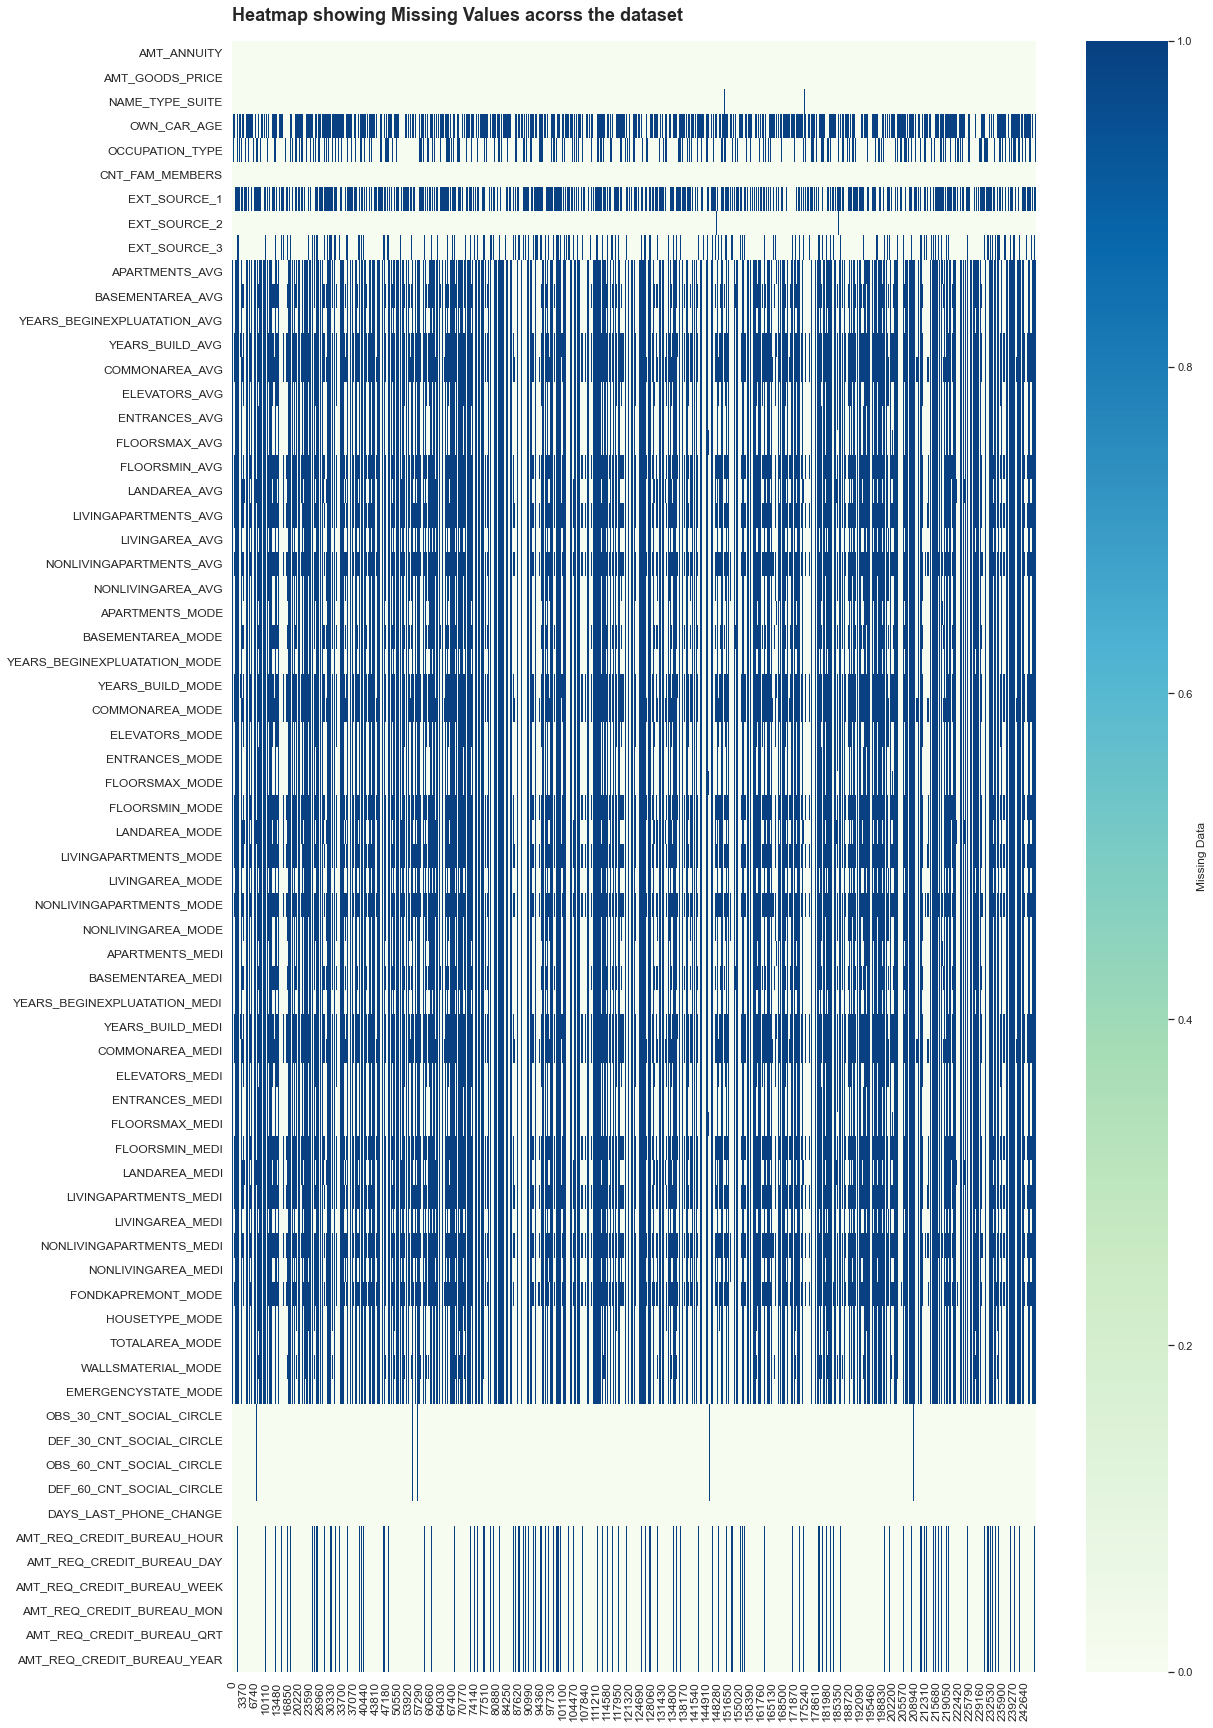

In [9]:
# heatmap showing null values
plt.figure(figsize=(18,30))
sns.heatmap(df_train.loc[:, df_train.isna().any()].isna().transpose(),
			cmap="GnBu",
			cbar_kws={'label': 'Missing Data'})
plt.title('Heatmap showing Missing Values acorss the dataset', weight='bold', fontsize=18, pad=20, loc='left')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show();

In [10]:
print(f'Data loss if removing all null values: {abs((df_train.dropna().size / df_train.size) - 1 * 100):.2f} %')

Data loss if removing all null values: 99.97 %


**Conclusion** 
   
Since a considerable amount of null values is dispersed across many observations and features, no column will be removed since we can't predict those impacts on the model. These values will be adressed later with [**Sklearn Impute**](#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) module.  

### <span id='dtypes' style='color:#1696d2'>Features types

Number of features by `dtype`

In [11]:
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Visualizing features with type = `float64`

Numeric discrete variables: 65


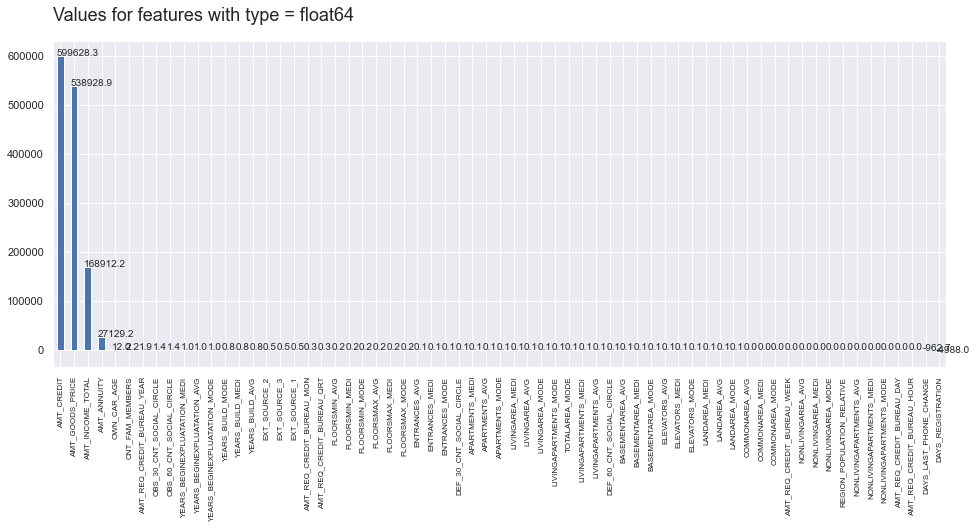

In [12]:
plt.figure(figsize=(16,6))
plot_data = df_train.select_dtypes(include='float64').mean().sort_values(ascending=False)
plot_data.plot(kind='bar')
plt.title('Values for features with type = float64', loc='left', size=18, pad=20)
# get xticks to write values on top of each bar
xlocs, xlabs = plt.xticks()
for i, v in enumerate(plot_data.round(1)):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v), size=10)
plt.xticks(xlocs, xlabs, size=8);
print(f'Numeric discrete variables: {df_train.select_dtypes(include="float64").shape[1]}')

A small portion of features with type `float64` have large values, thus applying a scaled method in the data will be needed before modeling.

Visualizing features with type = `int64`

Numeric discrete variables: 41


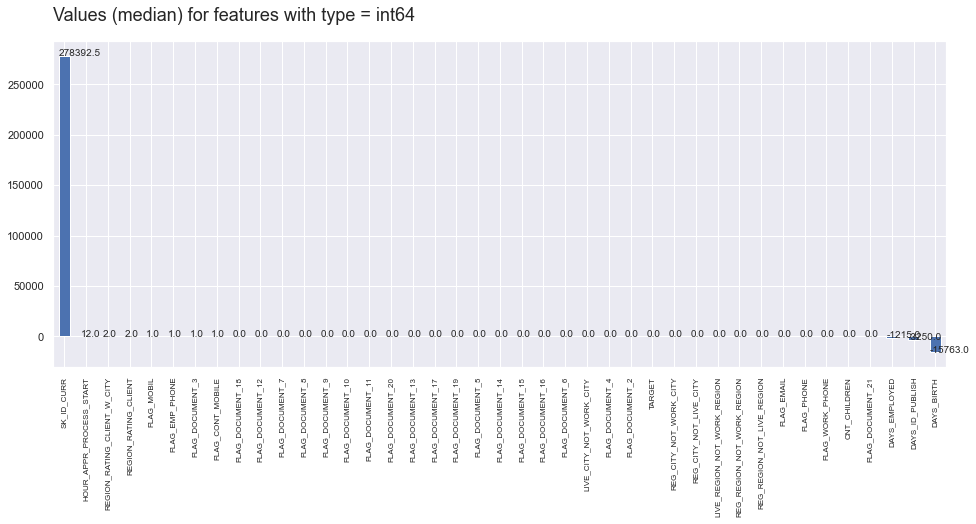

In [13]:
plt.figure(figsize=(16,6))
plot_data = df_train.select_dtypes(include='int64').median().sort_values(ascending=False)
plot_data.plot(kind='bar')
plt.title('Values (median) for features with type = int64', loc='left', size=18, pad=20)
# get xticks to write values on top of each bar
xlocs, xlabs = plt.xticks()
for i, v in enumerate(plot_data.round(1)):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v), size=10)
plt.xticks(xlocs, xlabs, size=8);
print(f'Numeric discrete variables: {df_train.select_dtypes(include="int64").shape[1]}')

Visualizing categorical variables (`object`)

In [14]:
df_train.select_dtypes(include='object').head()

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           F            N               N   Unaccompanied   
1         Cash loans           F            N               N   Unaccompanied   
2         Cash loans           M            Y               N   Unaccompanied   
3         Cash loans           F            N               Y   Unaccompanied   
4         Cash loans           F            N               Y   Unaccompanied   

       NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0               Working              Incomplete higher  Single / not married   
1  Commercial associate  Secondary / secondary special               Married   
2               Working  Secondary / secondary special               Married   
3             Pensioner  Secondary / secondary special               Married   
4               Working  Secondary / secondary special             Separated   

   NAME_HOUSING_TYPE        OCCUPATION_TYPE WEEKDAY_APPR_PROCESS_START  \
0  House / apartment             Core staff                     FRIDAY   
1  House / apartment  High skill tech staff                     MONDAY   
2  House / apartment               Managers                   THURSDAY   
3  House / apartment                    NaN                    TUESDAY   
4  House / apartment               Laborers                     FRIDAY   

        ORGANIZATION_TYPE FONDKAPREMONT_MODE  HOUSETYPE_MODE  \
0           Trade: type 2   reg oper account  block of flats   
1  Business Entity Type 3   reg oper account  block of flats   
2  Business Entity Type 1                NaN             NaN   
3                     XNA                NaN             NaN   
4       Transport: type 4   reg oper account  block of flats   

  WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
0              Block                  No  
1              Block                  No  
2                NaN                 NaN  
3                NaN                  No  
4              Panel                  No

Unique values per feature.

In [15]:
df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
for column in df_train.select_dtypes(include='object').drop('ORGANIZATION_TYPE', axis=1).nunique().sort_values(ascending=False).index:
	print(f'{CYAN}{column}: {WHITE}{df_train[column].unique()}')

OCCUPATION_TYPE: ['Core staff' 'High skill tech staff' 'Managers' nan 'Laborers' 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Accountants'
 'Low-skill Laborers' 'Security staff' 'Realty agents'
 'Private service staff' 'Medicine staff' 'Secretaries' 'HR staff'
 'Waiters/barmen staff' 'IT staff']
NAME_INCOME_TYPE: ['Working' 'Commercial associate' 'Pensioner' 'State servant'
 'Businessman' 'Unemployed' 'Student' 'Maternity leave']
NAME_TYPE_SUITE: ['Unaccompanied' 'Family' 'Spouse, partner' 'Other_B' 'Children' 'Other_A'
 nan 'Group of people']
WEEKDAY_APPR_PROCESS_START: ['FRIDAY' 'MONDAY' 'THURSDAY' 'TUESDAY' 'SATURDAY' 'WEDNESDAY' 'SUNDAY']
WALLSMATERIAL_MODE: ['Block' nan 'Panel' 'Stone, brick' 'Monolithic' 'Others' 'Wooden' 'Mixed']
NAME_FAMILY_STATUS: ['Single / not married' 'Married' 'Separated' 'Widow' 'Civil marriage'
 'Unknown']
NAME_HOUSING_TYPE: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Co-op apartment' 'Office apartment']
N

Some categorical features have a huge number of values, they need to be properly converted before starts modeling.

### <span id='encoding' style='color:#1696d2'>Encoding categorical variables

There are 2 options for encoding variables:   
1. **One Hot Encoder**: for unordered data.  
Create a new column for each unique value, with 0 or 1 indicating its correspondence.  
  
2. **Ordinal Encoder**: for ordered data.  
Each unique value of the category will be converted into an integer according to its importance, i.e. higher the value, higher the weight of that observation.  
  

*Discussion*: some observations seem to make sense to be ordered, like `NAME_EDUCATION_TYPE` or `OCCUPATION_TYPE`, but we can't make the affimation that based on the values of these categories a person will be more likely to pay off their debt, i.e. `TARGET`=1.  
Making this assumption can introduce bias in our analysis, so all categorical variables will be treated as *unordered data*.  

*One Hot Encoding* can be either made with `pd.get_dummies()` function or `sklearn` `OneHotEncoder` transformer.  
  
We will use `OneHotEndocer` transformer later in the pipeline, but for now we can make a copy of the dataset with `pd.get_dummies()` to finish our exploratory data analysis, and see if there is an impact on the correlations.  

In [17]:
# make a copy of the dataframe
df_train_copy = df_train.copy()
# apply onehot encoding with get_dummies
dummies = pd.get_dummies(df_train_copy.select_dtypes(include='object'))
# drop original categorical features
df_train_copy.drop(df_train_copy.select_dtypes(include='object').columns, axis=1, inplace=True)
# join dataframes
df_train_onehot = pd.concat([df_train_copy, dummies], axis=1)
print(f'Transformed data frame has {df_train_onehot.shape[1] - df_train.shape[1]} new columns, total = {df_train_onehot.shape[1]}')
df_train_onehot.head()

Transformed data frame has 124 new columns, total = 246


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      456162       0             0        112500.000  700830.000   
1      134978       0             0         90000.000  375322.500   
2      318952       0             0        180000.000  544491.000   
3      361264       0             0        270000.000  814041.000   
4      260639       0             0        144000.000  675000.000   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0    22738.500       585000.000                       0.020       -8676   
1    14422.500       324000.000                       0.025      -13583   
2    16047.000       454500.000                       0.036      -13993   
3    28971.000       679500.000                       0.046      -22425   
4    21906.000       675000.000                       0.026      -18839   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0           -813          -4163.000            -1363          NaN           1   
1           -223          -3554.000            -3287          NaN           1   
2          -6202          -7971.000            -4175        9.000           1   
3         365243         -11805.000            -1732          NaN           1   
4          -2763          -5069.000            -2381          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                1                 1           0           0   
1               1                0                 1           0           0   
2               1                1                 1           0           0   
3               0                0                 1           1           0   
4               1                0                 1           1           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0            1.000                     2                            2   
1            2.000                     2                            2   
2            2.000                     2                            2   
3            2.000                     1                            1   
4            1.000                     2                            2   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       17                           0   
1                       11                           0   
2                       15                           0   
3                        9                           0   
4                       16                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       1                       1                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       0                        0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0           NaN         0.699         0.171           0.062             0.030   
1         0.541         0.200         0.769           0.023             0.057   
2           NaN         0.705         0.626             NaN               NaN   
3           NaN         0.725         0.811             NaN               NaN   
4         0.592         0.706         0.331           0.191             0.180   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COM

### <span id='corr' style='color:#1696d2'>Data correlation

In [19]:
# get correlation from dataframe
df_corr = df_train.corr()
# set the upper triangle of the dataframe to zero for a cleaner display
half_df_corr = pd.DataFrame(np.triu(df_corr)!=0, columns=df_corr.columns, index=df_corr.index)
df_corr[half_df_corr] = 0
# plot heatmap
fig = px.imshow(df_corr, color_continuous_scale='RdBu_r', origin='lower')
fig.update_layout(
	title='Correlation Heatmap',
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(l=50, r=50, b=50, t=100, pad=4)
)
fig.show()

### <span id='target_dist' style='color:#1696d2'>Target distribuition

#### Check if `TARGET` distribution is balanced

In [18]:
# create a temporary data frame with TARGET value counts
_df = df_train['TARGET'].value_counts(dropna=False).rename_axis('TARGET').reset_index(name='counts').astype('object')
# plot figure
fig = px.bar(data_frame=_df, x='TARGET', y='counts', color='TARGET', width=600, title='Target Distribuition',
			color_discrete_map={
				0: 'rgba(22, 150, 210, 0.9)',
				1: 'rgba(92, 88, 89, 0.9)'
			})
fig.show()

`TARGET` variable is very unbalanced, for this will be important to **stratify** our data during the construction of the model.  

#### Analyze top correlations with `TARGET`

In [49]:
print('Five most negative correlation with TARGET:')
display(df_train.corr()['TARGET'].sort_values()[:5]) # exclude target, since corr = 1
print('Five most positive correlation with TARGET:')
display(df_train.corr()['TARGET'].sort_values(ascending=False)[1:6])

Five most negative correlation with TARGET:


EXT_SOURCE_3    -0.179
EXT_SOURCE_2    -0.161
EXT_SOURCE_1    -0.159
DAYS_EMPLOYED   -0.045
FLOORSMAX_AVG   -0.044
Name: TARGET, dtype: float64

Five most positive correlation with TARGET:


DAYS_BIRTH                    0.079
REGION_RATING_CLIENT_W_CITY   0.062
REGION_RATING_CLIENT          0.059
DAYS_LAST_PHONE_CHANGE        0.054
DAYS_ID_PUBLISH               0.052
Name: TARGET, dtype: float64

#### Same analysis for the Data Frame with One Hot Encoding

In [48]:
print('Five most negative correlation with TARGET:')
display(df_train_onehot.corr()['TARGET'].sort_values()[:5])
print('Five most positive correlation with TARGET:')
display(df_train_onehot.corr()['TARGET'].sort_values(ascending=False)[1:6])

Five most negative correlation with TARGET:


EXT_SOURCE_3                           -0.179
EXT_SOURCE_2                           -0.161
EXT_SOURCE_1                           -0.159
NAME_EDUCATION_TYPE_Higher education   -0.057
CODE_GENDER_F                          -0.055
Name: TARGET, dtype: float64

Five most positive correlation with TARGET:


DAYS_BIRTH                    0.079
REGION_RATING_CLIENT_W_CITY   0.062
REGION_RATING_CLIENT          0.059
NAME_INCOME_TYPE_Working      0.056
CODE_GENDER_M                 0.055
Name: TARGET, dtype: float64

For `GENDER` values, we have `F` indicating a negative correlation and `M` indicating a positive correlation. This is a sensitive information, because we can risk to create a model that will have a bias towards a gender. When the model is complete, we need to rank the importance of the features and analyse if the algorithm have indeed introduced this bias.  

Features like `EXT_SOURCE_n` have a weak negative correlation, let's see the description:

In [52]:
df_description.query('Row.str.contains("EXT_SOURCE")', engine='python')

Table           Row  \
41  application_{train|test}.csv  EXT_SOURCE_1   
42  application_{train|test}.csv  EXT_SOURCE_2   
43  application_{train|test}.csv  EXT_SOURCE_3   

                                   Description     Special  
41  Normalized score from external data source  normalized  
42  Normalized score from external data source  normalized  
43  Normalized score from external data source  normalized

`TARGET` distribuition with each `EXT_SOURCE` features

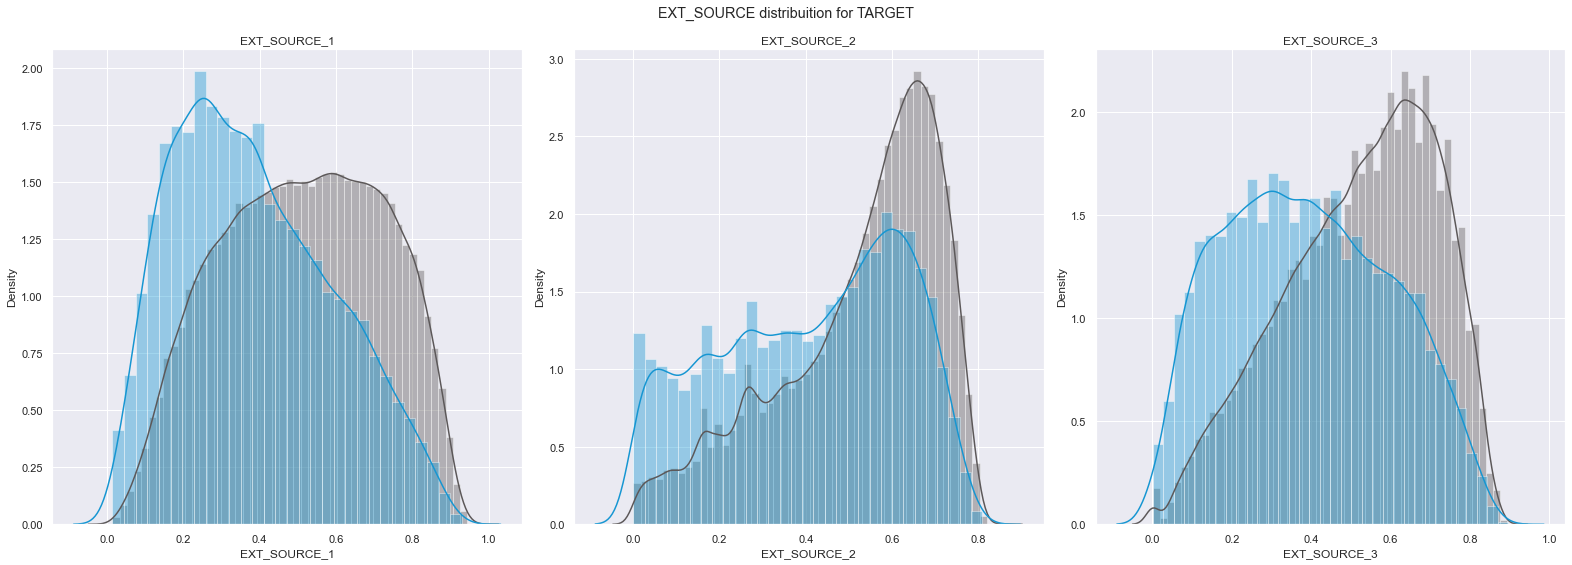

In [83]:
fig, ax = plt.subplots(1,3,figsize=(22,8))
for index, feature in enumerate(['EXT_SOURCE_' + str(i) for i in range(1,4)]):
	sns.distplot(df_train.query('TARGET == 0')[feature], kde=True, color=colors['gray'], ax=ax[index])
	sns.distplot(df_train.query('TARGET == 1')[feature], kde=True, color=colors['cyan'], ax=ax[index])
	ax[index].set_title(feature)
plt.suptitle('EXT_SOURCE distribuition for TARGET')
plt.tight_layout();

### <span id='outliers' style='color:#1696d2'>Search for Outliers

##

## <span id='baseline' style='color:Gold'>3. First Cycle - Baseline Model

For the baseline model, we will create a pipeline with the following steps:  
- Split data into train/test;  
- Deal NA values with `sklearn SimpleImputer`, with `strategy=mean` for numeric features and  `strategy=constant` with `'unknow'` value for categorical features;  
- Scale data using `StandartScaler`;  
- Use `LogisticRegression` as the baseline estimator.  

#### Split data into train/test and stratify with Target

In [126]:
from sklearn.model_selection import train_test_split

X = df_train.dropna().drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train.dropna()['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

#### Set pipeline for *numeric features*

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [128]:
numeric_features_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy='mean')),
    ('std', MinMaxScaler())
])

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

#### Set pipeline for *categorical features*

In [129]:
categorical_features_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

#### Create a pre-processing pipeline for `ColumnTransformer`

In [130]:
from sklearn.compose import ColumnTransformer

pre_processing_pipeline = ColumnTransformer([
    ('numeric_transformer', numeric_features_pipeline, numeric_features),
    ('categorical_transformer', categorical_features_pipeline ,categorical_features)
])

#### Create `Pipeline` and fit model

In [131]:
from sklearn.linear_model import LogisticRegression

# create final pipeline
baseline_pipeline = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(random_state=42))
])
# fit to model
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

#### Predict values from train and test dataset

In [42]:
y_pred_train = baseline_pipeline.predict(X_train)
y_pred_test = baseline_pipeline.predict(X_test)
y_proba_train = baseline_pipeline.predict_proba(X_train)
y_proba_test = baseline_pipeline.predict_proba(X_test)

#### Evaluate baseline model metrics with `roc_auc_score`

ROC AUC Score for Train dataset: 0.8269412673432549
ROC AUC Score for Test dataset: 0.7161604302378428

Train data Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5151
           1       0.73      0.02      0.05       329

    accuracy                           0.94      5480
   macro avg       0.83      0.51      0.51      5480
weighted avg       0.93      0.94      0.91      5480

Test data Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1288
           1       0.00      0.00      0.00        82

    accuracy                           0.94      1370
   macro avg       0.47      0.50      0.48      1370
weighted avg       0.88      0.94      0.91      1370



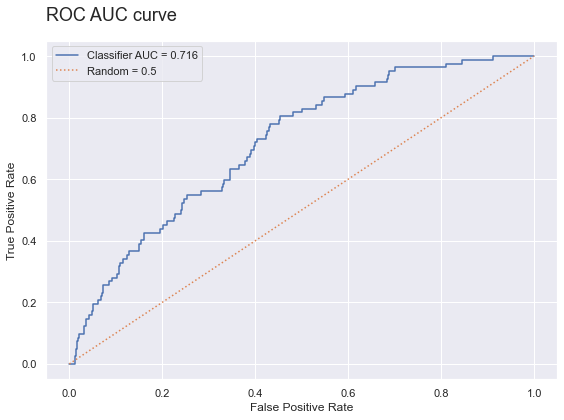

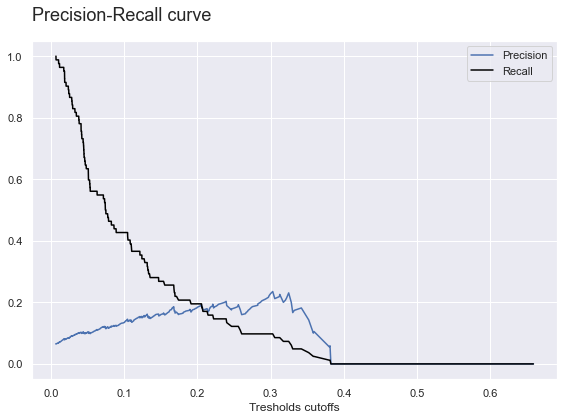

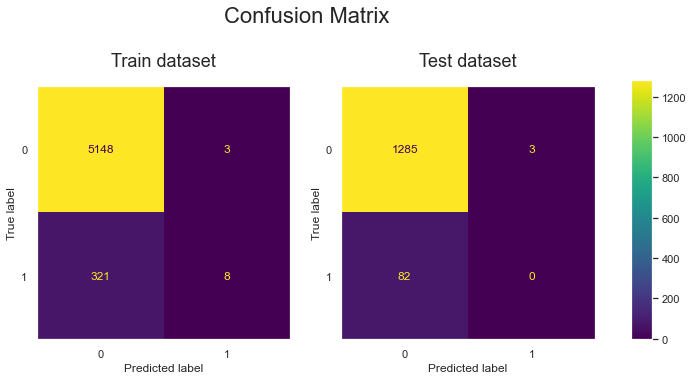

In [132]:
display_classification_metrics(baseline_pipeline, X_train, X_test, y_train, y_test)

The baseline model hit a score of **0.716**.  
  
For the next cycle, we will apply hyperparameter tunning and use different estimators, like `RandomForest` and `GradientBoosting`

#### Saving model

In [44]:
# saving baseline_pipeline
with open('pickle_data/baseline_model.pickle', 'wb') as file:
    pickle.dump(baseline_pipeline, file, protocol=pickle.HIGHEST_PROTOCOL)

## <span id='cycle2' style='color:Gold'>4. Second Cycle - Improving Model with Hyper-parameter tunning

For the hyperparameter tunning, `StratifiedKFold` will be used as the cross-validation method, `RandomizedSearchCV` to search for possible best hyperparameters, and finally `GridSearchCV` to fine tune.  

### <span id='lr+' style='color:#1696d2'>Improving Logistic Regression

In [133]:
from sklearn.model_selection import cross_val_score


cross_val_score(Pipeline([
						('pre_processing', pre_processing_pipeline),
						('lr', LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', random_state=42))
					]),
				X, y, cv=5, scoring='roc_auc').mean()

0.7499939334551378

#### Broad search for hyper-parameter with `RandomizedSearchCV`

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

# baseline pipeline
baseline_pipeline = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5, random_state=42))
])

# hyperparameters candidates for LogisticRegression
params_dist_lr = {
                'lr__C' : np.linspace(0,5,500),
                'lr__l1_ratio' : uniform(loc=0, scale=1)
                } 

# instance of the cross-validation method
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# instance of RandomizedSearchCV
random_lr = RandomizedSearchCV(estimator=baseline_pipeline,
                              param_distributions=params_dist_lr,
                              n_iter=10,
                              scoring='roc_auc',
                              cv=splitter,
                              verbose=10,
                              random_state=42)

# search for best hyperparameters
random_lr.fit(X_train, y_train)

Best parameters for `LogisticRegression` using `RandomizedSearchCV`

In [31]:
random_lr.best_params_

{'lr__C': 0.2004008016032064,
 'lr__l1_ratio': 0.450499251969543,
 'lr__max_iter': 628}

Best score for `LogisticRegression` using `RandomizedSearchCV`

In [32]:
random_lr.best_score_

0.7522719948902467

In [33]:
# remove prefix from the dictionary keys
random_lr_best_params = random_lr.best_params_.copy()
for key in random_lr_best_params.keys():
	random_lr_best_params[key.split('__')[-1]] = random_lr_best_params.pop(key)

best_random_lr = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(**random_lr_best_params, penalty='elasticnet', solver='saga', random_state=42))
]).fit(X_train, y_train)

print(f'ROC AUC Score with RandomizedSearchCV best params: {roc_auc_score(y_test, best_random_lr.predict_proba(X_test)[:,1]):.3f}')

ROC AUC Score with RandomizedSearchCV best params: 0.726


In [34]:
pd.DataFrame(random_lr.cv_results_).sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_lr__C  \
13         12.911         1.441            0.026           0.004       0.200   
0           3.124         0.065            0.026           0.002       1.022   
12          4.229         0.628            0.026           0.003       1.303   
3           3.646         0.813            0.027           0.007       3.727   
2           2.904         0.164            0.023           0.002       4.669   
16          5.579         0.577            0.053           0.031       3.397   
10          4.404         0.331            0.025           0.004       4.760   
17          7.871         1.784            0.041           0.016       4.279   
5           5.251         0.236            0.021           0.001       3.437   
7           6.333         1.278            0.026           0.009       1.603   
11          6.431         2.422            0.027           0.008       3.637   
19          6.604         1.229            0.024           0.005       3.597   
1           8.869         0.531            0.023           0.001       1.884   
9           8.625         0.648            0.027           0.007       4.749   
14         14.725         2.138            0.023           0.002       3.878   
18         17.224         3.415            0.039           0.022       2.054   
4          11.997         1.108            0.024           0.008       1.303   
8          18.202         1.810            0.026           0.003       2.525   
15         14.432         0.792            0.024           0.002       2.645   
6          14.728         0.643            0.022           0.001       3.858   

   param_lr__l1_ratio param_lr__max_iter  \
13              0.450                628   
0               0.797                148   
12              0.860                177   
3               0.601                148   
2               0.100                148   
16              0.241                177   
10              0.974                213   
17              0.495                213   
5               0.832                270   
7               0.304                270   
11              0.514                250   
19              0.755                270   
1               0.597                418   
9               0.612                418   
14              0.942                628   
18              0.391                628   
4               0.021                628   
8               0.432                816   
15              0.016                628   
6               0.182                803   

                                               params  split0_test_score  \
13  {'lr__C': 0.2004008016032064, 'lr__l1_ratio': ...              0.809   
0   {'lr__C': 1.0220440881763526, 'lr__l1_ratio': ...              0.801   
12  {'lr__C': 1.3026052104208417, 'lr__l1_ratio': ...              0.798   
3   {'lr__C': 3.727454909819639, 'lr__l1_ratio': 0...              0.795   
2   {'lr__C': 4.669338677354709, 'lr__l1_ratio': 0...              0.794   
16  {'lr__C': 3.3967935871743484, 'lr__l1_ratio': ...              0.792   
10  {'lr__C': 4.759519038076152, 'lr__l1_ratio': 0...              0.791   
17  {'lr__C': 4.278557114228457, 'lr__l1_ratio': 0...              0.790   
5   {'lr__C': 3.4368737474949898, 'lr__l1_ratio': ...              0.789   
7   {'lr__C': 1.6032064128256511, 'lr__l1_ratio': ...              0.789   
11  {'lr__C': 3.6372745490981964, 'lr__l1_ratio': ...              0.788   
19  {'lr__C': 3.597194388777555, 'lr__l1_ratio': 0...              0.788   
1   {'lr__C': 1.8837675350701402, 'lr__l1_ratio': ...              0.786   
9   {'lr__C': 4.749498997995992, 'lr__l1_ratio': 0...              0.781   
14  {'lr__C': 3.877755511022044, 'lr__l1_ratio': 0...              0.780   
18  {'lr__C': 2.0541082164328657, 'lr__l1_ratio': ...              0.780   
4   {'lr__C': 1.3026052104208417, 'lr__l1_ratio': ...              0.776   
8   {'lr__C': 2.52505010020040

#### Fine tunning with `GridSearchCV`

In [53]:
from sklearn.model_selection import GridSearchCV

# baseline pipeline
baseline_pipeline = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, random_state=42))
])

# hyperparameters candidates for LogisticRegression
params_grid_lr = {
                'lr__C' : np.linspace(0.2,2,10),
                'lr__l1_ratio' : np.linspace(0.35,0.55,10)
                } 

# instance of the cross-validation method
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# instance of RandomizedSearchCV
grid_lr = GridSearchCV(estimator=baseline_pipeline,
                        param_grid=params_grid_lr,
                        scoring='roc_auc',
                        cv=splitter,
                        verbose=10)

# search for best hyperparameters
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START lr__C=0.2, lr__l1_ratio=0.35..............................
[CV 1/5; 1/100] END lr__C=0.2, lr__l1_ratio=0.35;, score=0.809 total time=   3.3s
[CV 2/5; 1/100] START lr__C=0.2, lr__l1_ratio=0.35..............................
[CV 2/5; 1/100] END lr__C=0.2, lr__l1_ratio=0.35;, score=0.793 total time=   3.4s
[CV 3/5; 1/100] START lr__C=0.2, lr__l1_ratio=0.35..............................
[CV 3/5; 1/100] END lr__C=0.2, lr__l1_ratio=0.35;, score=0.702 total time=   2.2s
[CV 4/5; 1/100] START lr__C=0.2, lr__l1_ratio=0.35..............................
[CV 4/5; 1/100] END lr__C=0.2, lr__l1_ratio=0.35;, score=0.752 total time=   2.4s
[CV 5/5; 1/100] START lr__C=0.2, lr__l1_ratio=0.35..............................
[CV 5/5; 1/100] END lr__C=0.2, lr__l1_ratio=0.35;, score=0.713 total time=   2.4s
[CV 1/5; 2/100] START lr__C=0.2, lr__l1_ratio=0.37222222222222223...............
[CV 1/5; 2/100] END lr__C=0.2, lr__l1_rat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processing',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT

Best parameters for `LogisticRegression` using `GridSearchCV`

In [54]:
grid_lr.best_params_

{'lr__C': 0.2, 'lr__l1_ratio': 0.55}

Best score for `LogisticRegression` using `GridSearchCV`

In [59]:
grid_lr.best_score_

0.7562830615593981

In [61]:
# remove prefix from the dictionary keys
grid_lr_best_params = grid_lr.best_params_.copy()
for key in grid_lr.best_params_.keys():
	grid_lr_best_params[key.split('__')[-1]] = grid_lr_best_params.pop(key)

best_grid_lr = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(**grid_lr_best_params, penalty='elasticnet', solver='saga', random_state=42))
]).fit(X_train, y_train)

print(f'ROC AUC Score with RandomizedSearchCV best params: {roc_auc_score(y_test, best_grid_lr.predict_proba(X_test)[:,1]):.3f}')

ROC AUC Score with RandomizedSearchCV best params: 0.722


#### Optmized search with `hyperopt`

Another method to find better hyper-parameters is performing search with [`hyperopt`](#http://hyperopt.github.io/hyperopt/) library.  
This algorithm uses bayesian optimization to improve the results.  

In [ ]:
# hyperopt imports
from hyperopt import Trials, hp, tpe, fmin, space_eval
# cross validate method to be used with hyperopt
from sklearn.model_selection import cross_validate

Steps:  
- Create our **hps_space**, a dictionary with every hyper-parameter and possible range of values  
- Define our objective function, it will contain our *pipeline*, *cross-validation transformer* and returns a *score*  
- Run the function with `fmin()`  
- Evaluate results with `space_eval()`  

In [137]:
# define the parameters space
hps_space = {
            'C' :           hp.choice('C', np.linspace(0,5,500)),
            'l1_ratio' :    hp.choice('l1_ratio', np.linspace(0,1,50))
            }

# create the objective function
def objective_function(hps_space):
    # pipeline with the pre-processing steps and the estimator to be used
    pipeline =  Pipeline([('pp', pre_processing_pipeline),
                        ('lr', LogisticRegression(**hps_space, # assign space like a kwargs variable
                                                    penalty='elasticnet', solver='saga', max_iter=1000, random_state=42))]
                ) 
    #   splitter to be used in the cross validation step
    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    # make cross validation 
    results = cross_validate(pipeline,
                             X_train, y_train, 
                             cv=splitter,
                             scoring='roc_auc',
                             n_jobs=-1)
    # return the mean from cross validation results
    return -results['test_score'].mean() #  -1 ?

# perform hyperparameter tunning
lr_hps_search = fmin(fn=objective_function,
                    space=hps_space,
                    algo=tpe.suggest,
                    trials=Trials(),
                    rstate=np.random.default_rng(42),
                    max_evals=10)

100%|██████████| 10/10 [03:50<00:00, 23.01s/trial, best loss: -0.7548959996024304]


In [138]:
# get results
lr_hps_best_params = space_eval(hps_space, lr_hps_search)
print(f'LogisticRegression best parameters: {lr_hps_best_params}')

# create pipeline with the best parameters
lr_model = Pipeline([('pp', pre_processing_pipeline),
                    ('lr', LogisticRegression(**lr_hps_best_params, penalty='elasticnet', solver='saga', random_state=42))]
            ).fit(X_train, y_train)

# print score
lr_hps_score = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])
print(f'ROC AUC score for LogisticRegression: {lr_hps_score:.3f}')

LogisticRegression best parameters: {'C': 0.32064128256513025, 'l1_ratio': 0.4693877551020408}
ROC AUC score for LogisticRegression: 0.729


#### Saving model

In [86]:
# saving gridsearch pipeline
with open('pickle_data/2C_lr_grid.pickle', 'wb') as file:
    pickle.dump(grid_lr, file, protocol=pickle.HIGHEST_PROTOCOL)

## <span id='cycle3' style='color:Gold'>5. Third Cycle - Using other estimators

For all the following estimators, the first search will be with `hyperpot`, and later fine tuned with `GridSearchCV`

### <span id='rf' style='color:#1696d2'>Random Forest

The `RandomForestClassifier` estimator is more powerfull than `Logistic Regression`, for using the concept of *Bagging*(Bootsrap Aggregating) to generate random independent trees and make the final prediction throught the average of each individual prediction.  
  
This approach tends to remove some erros and outliers, making a model more generic an stable to overfitting.  
The most important parameters are:  
- `n_estimators`: how many trees will be build. More trees will take a longer time to finish, and starts to loses its individual properties.  
- `max_features`: number of features in the random sample to be used in each split. Less imply to reduce overfitting, but can lead to underfitting.  


In [87]:
from sklearn.ensemble import RandomForestClassifier

hps_space = {'criterion' : hp.choice('criterion', ['gini', 'entropy']),
             'n_estimators' : hp.choice('n_estimators', range(1, 501)),
             'max_depth' : hp.choice('max_depth', [1, 2])} # must be a low number, since the algorithm uses a 'weak learner'

def objective_function(hps_space):
    pipeline = Pipeline([('pp', pre_processing_pipeline),
                        ('rf', RandomForestClassifier(**hps_space, random_state=42))]) 
    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    results = cross_validate(pipeline, X_train, y_train, cv=splitter, scoring='roc_auc', n_jobs=-1)
    return results['test_score'].mean()

rf_hps_search = fmin(fn=objective_function, space=hps_space, algo=tpe.suggest, trials=Trials(), rstate=np.random.default_rng(42),
                    max_evals=50)

100%|██████████| 50/50 [02:52<00:00,  3.46s/trial, best loss: 0.5222136816378904]


Extrating the results with `space_eval`, fitting model and calculating the **ROC AUC score**

In [88]:
# using space_eval to extract the results
rf_hps_best_params = space_eval(hps_space, rf_hps_search)
print(f'RandomForest best parameters: {rf_hps_best_params}')

# fit new model with the best parameters
rf_model = Pipeline([("pp", pre_processing_pipeline),
        ("rf", RandomForestClassifier(**rf_hps_best_params))]
).fit(X_train, y_train)

# validate metrics
rf_hps_score = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print(f'ROC AUC score for Random Forest: {rf_hps_score:.3f}')

RandomForest best parameters: {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 1}
ROC AUC score for Random Forest: 0.495


#### Saving model

In [89]:
# saving rf model
with open('pickle_data/2C_rf_model.pickle', 'wb') as file:
    pickle.dump(rf_model, file, protocol=pickle.HIGHEST_PROTOCOL)

### <span id='gb' style='color:#1696d2'>Gradient Boosting

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

In [96]:
hps_space = {'loss' : hp.choice('loss', ['deviance', 'exponential']),
             'n_estimators' : hp.choice('n_estimators', range(1, 501)),
             'max_depth' : hp.choice('max_depth', [1, 2])}

def objective_function(hps_space):
    pipeline = Pipeline([('pp', pre_processing_pipeline),
                        ('gb', GradientBoostingClassifier(**hps_space, random_state=42))]) 
    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    results = cross_validate(pipeline, X_train, y_train, cv=splitter, scoring='roc_auc', n_jobs=-1)
    return results['test_score'].mean()

gb_hps_search = fmin(fn=objective_function,
                    space=hps_space,
                    algo=tpe.suggest,
                    trials=Trials(),
                    rstate=np.random.default_rng(42),
                    max_evals=50)

100%|██████████| 50/50 [27:34<00:00, 33.09s/trial, best loss: 0.6141092347866335]


In [97]:
gb_hps_best_params = space_eval(hps_space, gb_hps_search)
print(f'Gradient Boosting best parameters: {gb_hps_best_params}')

gb_model = Pipeline([('pp', pre_processing_pipeline),
        ('gb', GradientBoostingClassifier(**gb_hps_best_params))]
).fit(X_train, y_train)

gb_hps_score = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:,1])
print(f'ROC AUC score for Gradient Boosting: {gb_hps_score:.3f}')

Gradient Boosting best parameters: {'loss': 'deviance', 'max_depth': 2, 'n_estimators': 1}
ROC AUC score for Gradient Boosting: 0.618


#### Saving model

In [98]:
# saving gb model
with open('pickle_data/2C_gb_model.pickle', 'wb') as file:
    pickle.dump(gb_model, file, protocol=pickle.HIGHEST_PROTOCOL)

### <span id='svm' style='color:#1696d2'>Support Vector Machine

In [102]:
from sklearn.svm import SVC

hps_space = {
                'C' :       hp.choice('C', np.logspace(-2, 2, 100)),
                'kernel' :  hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']),
                'degree' :  hp.choice('degree', range(3,6)),
                'gamma'  :  hp.choice('gamma', np.logspace(-2, 2, 100))
            }

def objective_function(hps_space):
    pipeline = Pipeline([('pp', pre_processing_pipeline),
                        ('svc', SVC(**hps_space, random_state=42))]) 
    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    results = cross_validate(pipeline, X_train, y_train, cv=splitter, scoring='roc_auc', n_jobs=-1)
    return results['test_score'].mean()

svc_hps_search = fmin(fn=objective_function,
                    space=hps_space,
                    algo=tpe.suggest,
                    trials=Trials(),
                    rstate=np.random.default_rng(42),
                    max_evals=15)

 53%|█████▎    | 8/15 [06:18<05:31, 47.30s/trial, best loss: 0.5293908070402755]


KeyboardInterrupt: 

In [ ]:
svc_hps_best_params = space_eval(hps_space, svc_hps_search)
print(f'SVC best parameters: {svc_hps_best_params}')

svc_model = Pipeline([("pp", pre_processing_pipeline),
                      ("gb", SVC(**svc_hps_best_params))]
).fit(X_train, y_train)

svc_hps_score = roc_auc_score(y_test, svc_model.predict_proba(X_test)[:,1])
print(f'ROC AUC score for SVC: {svc_hps_score:.3f}')

In [ ]:
# saving svc model
with open('pickle_data/2C_svc_model.pickle', 'wb') as file:
    pickle.dump(svc_model, file, protocol=pickle.HIGHEST_PROTOCOL)

### <span id='xgb' style='color:#1696d2'>XGBoost

In [134]:
from xgboost import XGBClassifier

pipe_xgb = Pipeline([("pre_processador", pre_processing_pipeline),
                     ("xgb", XGBClassifier(random_state=42))])

pipe_xgb.fit(X_train, y_train)

xgb_score = roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:,1])
print(f'ROC AUC score for XGB: {xgb_score:.3f}')

[21:35:15] WARNING: /private/var/folders/_m/3m0bcc4n6h73gny0bt6_g4x80000gn/T/pip-install-4m5tp6_t/xgboost_17c0d7c1e7cb4a3aab80bf74764ec6a2/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC score for XGB: 0.679


In [106]:
# saving svc model
with open('pickle_data/2C_xgb_model.pickle', 'wb') as file:
    pickle.dump(pipe_xgb, file, protocol=pickle.HIGHEST_PROTOCOL)

## <span id='saving' style='color:Gold'>6. Interpreting Model

<Figure size 720x720 with 0 Axes>

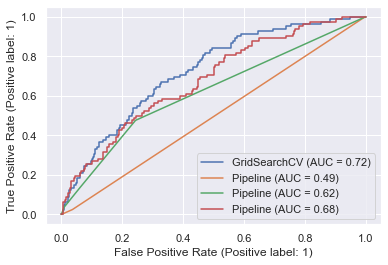

In [140]:
from sklearn.metrics import plot_roc_curve

plt.figure(figsize=(10,10))
disp = plot_roc_curve(grid_lr, X_test, y_test)
plot_roc_curve(rf_model, X_test, y_test, ax=disp.ax_)
plot_roc_curve(gb_model, X_test, y_test, ax=disp.ax_)
plot_roc_curve(pipe_xgb, X_test, y_test, ax=disp.ax_);

In [ ]:
from lime import lime_tabular
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [ ]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features =     X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

ct = make_column_transformer(
                (SimpleImputer(strategy='mean'),        numeric_features),
                (SimpleImputer(strategy='constant', 
                                fill_value='unknow'),   categorical_features),
                (MinMaxScaler(),                        numeric_features),
                (OneHotEncoder(),                       categorical_features),
                remainder='passthrough')

pipe = make_pipeline(ct,XGBClassifier(random_state=42))

pipe.fit(X_train, y_test)

print(f'Train score: {roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1]):.3f}')
print(f'Test score: {roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]):.3f}')

In [153]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# numeric
numeric_features_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy='mean')),
    ('std', MinMaxScaler())
])
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
# categorical
categorical_features_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()
# pre processing
pre_processing_pipeline = ColumnTransformer([
    ('numeric_transformer', numeric_features_pipeline, numeric_features),
    ('categorical_transformer', categorical_features_pipeline ,categorical_features)
])
# piepline
pipeline = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(random_state=42))
])
# fit to model
pipeline.fit(X_train, y_train)
# score
print(f'Train score: {roc_auc_score(y_train, pipeline.predict_proba(X_train)[:,1]):.3f}')
print(f'Test score: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]):.3f}')

Train score: 0.746
Test score: 0.745


In [150]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                              mode="classification",
                                              feature_names=pipeline.feature_names_in_,
                                              class_names=pipeline.classes_)

explanation = explainer.explain_instance(X_test.iloc[0],
                                         pipeline.predict_proba,
                                         num_features=pipeline.n_features_in_)

explanation.show_in_notebook()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

## <span id='deploy' style='color:Gold'>7. Deploy Model

# Submit Results

In [ ]:
# create submit dataframe with predictions from the best model
pd.DataFrame({
	'SK_ID_CURR': df_test['SK_ID_CURR'],
	'y_proba': grid_lr.predict_proba(df_test.drop('SK_ID_CURR', axis=1))[:,1]
	}).to_csv('submit_file.csv')